In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

In [2]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_full = discretize.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0']
)

# Add air resistivity
res_h_full = 1e8*np.ones(mesh_full.vnC)
res_v_full = 1e8*np.ones(mesh_full.vnC)
res_h_full[:, :, :-1] = tres_h
res_v_full[:, :, :-1] = tres_v
del data, tres_h, tres_v

mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

Text(0.5, 1.0, 'rho_v')

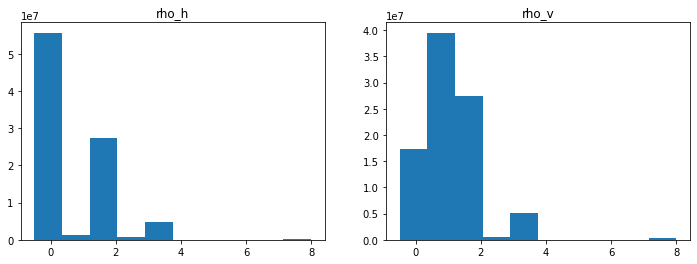

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

histh = ax[0].hist(np.log10(mkvc(res_h_full)), 10);
histv = ax[1].hist(np.log10(mkvc(res_v_full)), 10);

# ax[0].set_xlim([-1, 1])
# ax[1].set_xlim([-1, 1])

ax[0].set_title("rho_h")
ax[1].set_title("rho_v")

In [4]:
10**histh[1][0]

0.3199999928474426

In [5]:
10**histh[1][1]

2.262741654278355

In [6]:
10**histh[1][1] - 10**histh[1][0]

1.9427416614309125

In [7]:
np.min(np.log10(res_h_full)), np.min(np.log10(res_v_full))

(-0.49485003138733225, -0.49485003138733225)

In [8]:
np.min(res_h_full), np.min(res_v_full)

(0.3199999928474426, 0.3199999928474426)

In [9]:
%%time
# compute the total gradient
dmdx_h = np.abs(mesh_full._cellGradxStencil * mkvc(res_h_full))
dmdy_h = np.abs(mesh_full._cellGradyStencil * mkvc(res_h_full))
dmdz_h = np.abs(mesh_full._cellGradzStencil * mkvc(res_h_full))

CPU times: user 17.4 s, sys: 11 s, total: 28.4 s
Wall time: 28.4 s


In [10]:
%%time
# compute the total gradient
dmdx_v = np.abs(mesh_full._cellGradxStencil * mkvc(res_v_full))
dmdy_v = np.abs(mesh_full._cellGradyStencil * mkvc(res_v_full))
dmdz_v = np.abs(mesh_full._cellGradzStencil * mkvc(res_v_full))

CPU times: user 17.2 s, sys: 11.1 s, total: 28.4 s
Wall time: 28.4 s


In [11]:
dmdx_h_nz = np.nonzero(dmdx_h)[0]
dmdy_h_nz = np.nonzero(dmdy_h)[0]
dmdz_h_nz = np.nonzero(dmdz_h)[0]

In [12]:
dmdx_v_nz = np.nonzero(dmdx_v)[0]
dmdy_v_nz = np.nonzero(dmdy_v)[0]
dmdz_v_nz = np.nonzero(dmdz_v)[0]

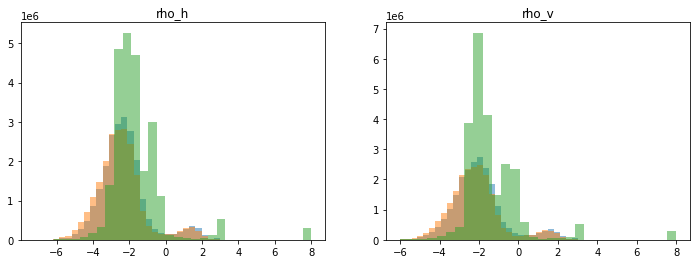

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for dim, h, v in zip(
    ["x", "y", "z"],
    [dmdx_h[dmdx_h_nz], dmdy_h[dmdy_h_nz], dmdz_h[dmdz_h_nz]],
    [dmdx_v[dmdx_v_nz], dmdy_v[dmdy_v_nz], dmdz_v[dmdz_v_nz]]
):

    ax[0].hist(np.log10(np.abs(mkvc(h))), 30, alpha=0.5);
    ax[1].hist(np.log10(np.abs(mkvc(v))), 30, alpha=0.5);

    ax[0].set_title("rho_h")
    ax[1].set_title("rho_v")

In [14]:
# average to cell centers and sum

dmdh = (
    mesh_full.aveFx2CC * dmdx_h + 
    mesh_full.aveFy2CC * dmdy_h + 
    mesh_full.aveFz2CC * dmdz_h
)

dmdv = (
    mesh_full.aveFx2CC * dmdx_v + 
    mesh_full.aveFy2CC * dmdy_v + 
    mesh_full.aveFz2CC * dmdz_v
)

In [15]:
dm = dmdh + dmdv

In [16]:
dm_nonzero = np.nonzero(dm)[0]

(array([8.0000000e+00, 1.8500000e+02, 3.2470000e+03, 3.0404000e+04,
        1.2459800e+05, 2.3574100e+05, 5.3933000e+05, 3.1231820e+06,
        5.4718920e+06, 1.3605903e+07, 7.4602590e+06, 7.8334060e+06,
        5.6419890e+06, 1.7179740e+06, 3.6301900e+05, 1.6212700e+05,
        2.9446200e+05, 6.2767800e+05, 4.8823100e+05, 1.2782330e+06,
        2.9898000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.7989000e+05]),
 array([-6.32162991, -5.84424225, -5.36685458, -4.88946692, -4.41207925,
        -3.93469159, -3.45730393, -2.97991626, -2.5025286 , -2.02514094,
        -1.54775327, -1.07036561, -0.59297795, -0.11559028,  0.36179738,
         0.83918504,  1.31657271,  1.79396037,  2.27134804,  2.7487357 ,
         3.22612336,  3.70351103,  4.18089869,  4.65828635,  5.13567402,
         5.61306168,  6.09044934,  6.56783701,  7.04522467,  7.52261234,
         8.        ]),
 <a list of 30 Patch ob

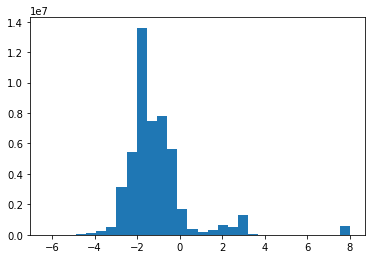

In [17]:
plt.hist(np.log10(dm[dm_nonzero]), 30)

In [161]:
threshold = 1
significant_dm = dm >= threshold

In [162]:
significant_dm.sum()

5040738

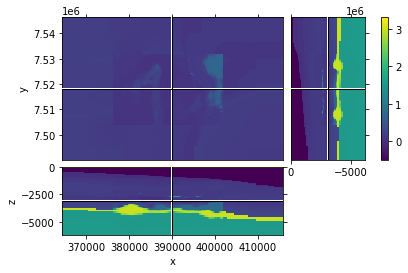

In [163]:
mesh_full.plot_3d_slicer(np.log10(res_h_full),  clim=[np.log10(0.32), np.log10(2000)])

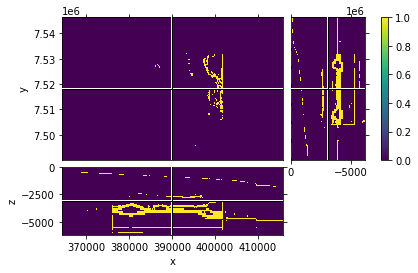

In [164]:
mesh_full.plot_3d_slicer(significant_dm)

## load survey info

In [165]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')

In [166]:
# Use reciprocity: rec becomes src
src = [
    ds.rec_x, ds.rec_y, ds.rec_z,
    ds.rec_theta, ds.rec_dip
]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

rec_locs_il = discretize.utils.ndgrid([rec_x.data, rec_y_il, rec_z_il])
rec_locs_bs = discretize.utils.ndgrid([rec_x.data, rec_y_bs, rec_z_bs])

# Frequency
freqs = ds.freqs.values

True


In [167]:
src

[390275.0, 7517812.0, -849.7838, 0.0, 0.0]

In [168]:
print(rec_x.max() - rec_x.min())
print(rec_y_il.max() - rec_y_il.min())
print(rec_y_bs.max() - rec_y_bs.min())
print(rec_z_il.max() - rec_z_il.min())
print(rec_z_bs.max() - rec_z_bs.min())

print(rec_z_bs.min(), rec_z_bs.max())
print(rec_z_il.min(), rec_z_il.max())

<xarray.DataArray 'src_x' ()>
array(21800., dtype=float32)
0.0
0.0
432.17328
429.44952
-1053.3586 -623.9091
-1034.6903 -602.517


In [169]:
# only refine in the core region where we are collecting data 

extra = 400. 

refine_points_core = significant_dm & (
    (mesh_full.gridCC[:, 0] > rec_x.data.min() - extra) &
    (mesh_full.gridCC[:, 0] < rec_x.data.max() + extra) & 
    (mesh_full.gridCC[:, 1] > rec_x.data.min()) &
    (mesh_full.gridCC[:, 1] > rec_x.data.max())
)

refine_points = mesh_full.gridCC[refine_points_core, :]

In [170]:
tmp = refine_points_core.nonzero()

In [171]:
tmp[0].shape

(3250017,)

In [172]:
significant_dm.nonzero()[0].shape

(5040738,)

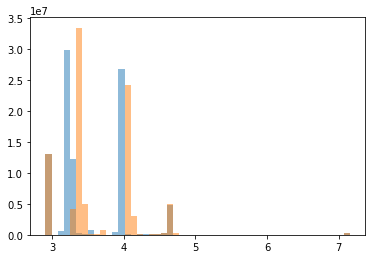

In [173]:
fig, ax = plt.subplots(1,1)
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_h_full))), 50, alpha=0.5);
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_v_full))), 50, alpha=0.5);

## design a mesh

In [183]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 200, 200, 80 

domain_x = float(rec_x.max() - rec_x.min())
domain_y = 0.4*domain_x 
domain_z = refine_points[:, 2].max() - refine_points[:, 2].min()

ncore_x = int(np.ceil(domain_x/dx))
ncore_y = int(np.ceil(domain_y/dy))
ncore_z = int(np.ceil(domain_z/dz))

print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

npad_x = 8
npad_y = 8
npad_z = 8

ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
ncy = 2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

print(ncx, ncy, ncz, ncx*ncy*ncz)

pf = 1.4


109 44 78 374088
128 64 128 1048576


In [184]:
mesh_full.x0

array([ 3.643250e+05,  7.490049e+06, -6.200000e+03])

In [185]:
mesh_full_center = np.r_[
    (mesh_full.gridCC[:, 0].min() + mesh_full.gridCC[:, 0].max())/2,
    (mesh_full.gridCC[:, 1].min() + mesh_full.gridCC[:, 1].max())/2,
    (mesh_full.gridCC[:, 2].min() + mesh_full.gridCC[:, 2].max())/2
]

In [186]:
# define the base mesh
mesh = discretize.TreeMesh(
    [
        [(dx, npad_x, -pf), (dx, ncx-npad_x*2), (dx, npad_x, pf)], 
        [(dy, npad_y, -pf), (dy, ncy-npad_y*2), (dy, npad_y, pf)], 
        [(dz, npad_z, -pf), (dz, ncz-npad_z*2), (dz, npad_z, pf)]
    ]
)

mesh.x0 = np.r_[
    -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2])/2.
] + mesh_full_center


# refine around the sources and receivers
src_refine = np.c_[src[0], src[1], src[2]]

mesh = discretize.utils.refine_tree_xyz(
    mesh, src_refine, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_il, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_bs, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

# refine around interesting surfaces
# this is currently not the best way to do this... 
# n_batches = 10
# n_values = np.ceil(refine_points.shape[0]/n_batches)
# for i in range(n_batches+1): 
#     inds = np.r_[int(i*n_values), int(np.min([(i+1)*n_values, refine_points.shape[0]]))]
#     print(i, inds)
mesh = discretize.utils.refine_tree_xyz(
    mesh, refine_points, 
    octree_levels=[1, 1], method="radial", finalize=False
)

mesh.finalize()

# return mesh

In [187]:
mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

In [188]:
mesh

OcTreeMesh: 34.48% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  4   :       430            ---------------------------   --------------------
  5   :      3362         x: 369244.476608,410905.523392     200.0   , 9630.523392000003
  6   :      36503        y: 7503768.476608,7532629.523391999     200.0   , 9630.523392000236
  7   :     321224        z: -11422.209356799998,5242.209356799998   79.99999999999909, 3852.209356799999
-----------------------
Total :     361519

In [204]:
mesh.nC

361519

In [205]:
src

[390275.0, 7517812.0, -849.7838, 0.0, 0.0]

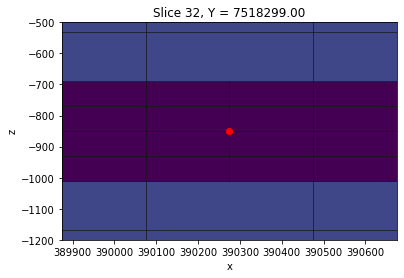

In [206]:
fig, ax = plt.subplots(1, 1)
mesh.plotSlice(np.log10(mesh.vol), normal='y', grid=True, ax=ax)
# ax.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_y)

ax.set_xlim(src[0] + 400*np.r_[-1, 1])
ax.set_ylim(np.r_[-1200, -500])

ax.plot(src[0], src[2], 'ro')

## Interpolate model from basemesh to simulation mesh

In [207]:
interpolate_inds = (
    (mesh.gridCC[:, 0] >= mesh_full.vectorNx.min()) & (mesh.gridCC[:, 0] <= mesh_full.vectorNx.max()) &
    (mesh.gridCC[:, 1] >= mesh_full.vectorNy.min()) & (mesh.gridCC[:, 1] <= mesh_full.vectorNy.max()) &
    (mesh.gridCC[:, 2] >= mesh_full.vectorNz.min()) & (mesh.gridCC[:, 2] <= mesh_full.vectorNz.max()) 
)
P = mesh_full.getInterpolationMat(mesh.gridCC[interpolate_inds, :], "CC")

In [208]:
rho_h = 1e8*np.ones(mesh.nC)
rho_v = 1e8*np.ones(mesh.nC)

rho_h[mesh.gridCC[:, 2] < 0] = res_h_full[-1, -1, 0]
rho_v[mesh.gridCC[:, 2] < 0] = res_v_full[-1, -1, 0]

In [209]:
rho_h[interpolate_inds] = P @ mkvc(res_h_full)
rho_v[interpolate_inds] = P @ mkvc(res_v_full)

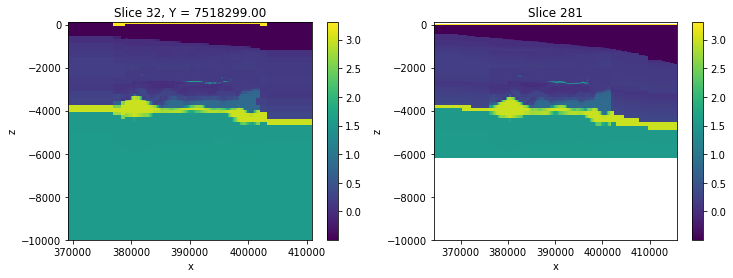

In [210]:
normal = "y"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh.plotSlice(
        np.log10(rho_h), normal=normal, ax=ax[0], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[0]
)

plt.colorbar(
    mesh_full.plotSlice(
        np.log10(mkvc(res_h_full)), normal=normal, ax=ax[1], clim=[np.log10(0.32), np.log10(2000)])[0], 
    ax=ax[1]
)

# ax.set_xlim(mesh.x0[1] + np.r_[-1, 1]*domain_y)
for a in ax: 
    a.set_ylim(np.r_[-10000, 100])

In [211]:
rho = np.vstack([rho_h, rho_h, rho_v]).T

# set up the survey

In [212]:
rx_list_e = []
rx_list_h = []
for rxlocs in [rec_locs_il, rec_locs_bs]:
    for orientation in ["x", "y", "z"]: 
        # e-field
        rx_list_e.append(
            fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_e.append(
                fdem.receivers.Point_e(locations=rxlocs, orientation=orientation, component="imag")
        )
        
        # h-field
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="real")
        )
        rx_list_h.append(
            fdem.receivers.Point_h(locations=rxlocs, orientation=orientation, component="imag")
        )

In [213]:
rx_list = rx_list_e + rx_list_h

In [214]:
Ps = mesh.getInterpolationMat(np.c_[src[0], src[1], src[2]], 'Ex')

In [215]:
src_ex = Ps.T @ np.r_[1]

In [216]:
mesh.gridEx[np.where(src_ex)[0], :]

array([[ 3.901750e+05,  7.517799e+06, -8.500000e+02],
       [ 3.901750e+05,  7.517799e+06, -7.700000e+02],
       [ 3.901750e+05,  7.517999e+06, -8.500000e+02],
       [ 3.901750e+05,  7.517999e+06, -7.700000e+02]])

In [217]:
source_list = [
    fdem.sources.RawVec_e(s_e=src_ex, freq=f, receiver_list=rx_list) 
    for f in freqs[:1]
]

In [218]:
survey = fdem.Survey(source_list)

In [219]:
sim = fdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, solver=Pardiso, rho=rho
)

In [ ]:
%%time
mem = %memit -o fields = sim.fields()
ram = f"{(mem.mem_usage[0] - mem.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram}")

In [ ]:
fields

In [ ]:
dpred = sim.dpred(f=fields)


In [ ]:
dpred